In [ ]:
import os 

import gym

import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class CEMAgent(nn.Module):
    def __init__(self, state_dim, action_n, loss_f=nn.CrossEntropyLoss()):
        super(CEMAgent, self).__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.net = nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n),
            nn.Softmax(dim=0))
        self.loss_f = loss_f

    def forward(self, x):
        return self.net(x)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = self(state)
        action = np.random.choice(self.action_n, p=action_probs.detach().numpy())
        return action

    def training_step(self, elite_trajectories):
        elite_states, elite_actions = [], []
        for t in elite_trajectories:
            elite_states.extend(t['states'])
            elite_actions.extend(t['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.LongTensor(np.array(elite_actions))
        out = self(elite_states)
        loss = self.loss_f(out, elite_actions)
        return loss * 10000

In [ ]:
def get_trajectory(env, agent, trajectory_len, viz=False):
    trajectory = {
        'states': [],
        'actions': [],
        'reward': 0
    }
    state = env.reset()
    trajectory['states'].append(state)
    for _ in range(trajectory_len):
        action = agent.get_action(state)
        state, reward, done, _ = env.step(action)
        trajectory['actions'].append(action)
        trajectory['reward'] += reward
        if viz:
            env.render()
        if done:
            break
        trajectory['states'].append(state)
    return trajectory


def get_elite_trajectories(trajectories, q_param):
    rewards = [t['reward'] for t in trajectories]
    q_value = np.quantile(rewards, q_param)
    return round(np.mean(rewards), 2), [t for t in trajectories if t['reward'] > q_value]

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]



def train(epochs, env, agent, traj_per_epoch, lr, trajectory_len=500, opt_f=torch.optim.SGD):
    history = {'loss': [], 'reward': [], 'q_param': [], 'lr': [], 'etn': []}
    
    opt = opt_f(agent.parameters(), lr=lr)
    
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=epochs, steps_per_epoch=1)
    q_sched = lambda epoch: max(0.2, (epoch / epochs)*0.9)

    start = time.perf_counter()
    loss = 0
    
    for epoch in range(epochs):
        trajectories = [get_trajectory(env, agent, trajectory_len) for _ in tqdm(range(traj_per_epoch), leave=True, colour='blue')]
        el_tr_n = 0
        loss = 0
        q_param = round(q_sched(epoch), 5)
        mean_reward, elite_trajectories = get_elite_trajectories(trajectories, q_param)
        
        if len(elite_trajectories) > 0:
            el_tr_n = len(elite_trajectories)
            loss = agent.training_step(elite_trajectories)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss = round(loss.item(), 2)
        last_lr = round(get_lr(opt), 5)
        history['loss'].append(loss)
        history['reward'].append(mean_reward)
        history['q_param'].append(q_param)
        history['lr'].append(last_lr)
        history['etn'].append(el_tr_n)

        print(f'Epoch [{epoch}] Mean reward [{mean_reward}] Loss [{round(loss, 2)}] Q param [{round(q_param, 3)}] Last lr[{round(last_lr, 4)}] Elite traj n [{el_tr_n}]')
        lr_scheduler.step()
    end = time.perf_counter()
    print(f'Training took {round(end-start, 4)} secs')
    return history


In [ ]:
env = gym.make("Acrobot-v1")
print('env created')

env created


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
state_dim = 6
action_n = 3
agent = CEMAgent(state_dim, action_n)

In [ ]:
epochs = 31
traj_per_epoch = 800
lr = 0.3
opt_f = torch.optim.Adam


history = train(epochs, env, agent, traj_per_epoch, lr)

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [0] Mean reward [-499.47] Loss [10986.13] Q param [0.2] Last lr[0.012] Elite traj n [4]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [1] Mean reward [-498.61] Loss [10986.12] Q param [0.2] Last lr[0.0222] Elite traj n [15]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [2] Mean reward [-497.91] Loss [10986.12] Q param [0.2] Last lr[0.0513] Elite traj n [22]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [3] Mean reward [-495.68] Loss [10986.12] Q param [0.2] Last lr[0.0953] Elite traj n [45]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [4] Mean reward [-480.71] Loss [10986.12] Q param [0.2] Last lr[0.1478] Elite traj n [175]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [5] Mean reward [-428.53] Loss [10986.12] Q param [0.2] Last lr[0.2015] Elite traj n [469]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [6] Mean reward [-358.06] Loss [10986.12] Q param [0.2] Last lr[0.2488] Elite traj n [639]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [7] Mean reward [-287.81] Loss [10986.12] Q param [0.203] Last lr[0.2829] Elite traj n [637]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [8] Mean reward [-243.8] Loss [10986.11] Q param [0.232] Last lr[0.2991] Elite traj n [614]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [9] Mean reward [-209.49] Loss [10986.1] Q param [0.261] Last lr[0.2992] Elite traj n [586]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [10] Mean reward [-182.15] Loss [10986.08] Q param [0.29] Last lr[0.2955] Elite traj n [568]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [11] Mean reward [-159.86] Loss [10986.05] Q param [0.319] Last lr[0.2887] Elite traj n [540]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [12] Mean reward [-142.04] Loss [10986.02] Q param [0.348] Last lr[0.279] Elite traj n [515]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [13] Mean reward [-132.23] Loss [10985.99] Q param [0.377] Last lr[0.2666] Elite traj n [487]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [14] Mean reward [-120.12] Loss [10985.97] Q param [0.406] Last lr[0.2518] Elite traj n [469]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [15] Mean reward [-114.11] Loss [10985.92] Q param [0.435] Last lr[0.2348] Elite traj n [426]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [16] Mean reward [-107.15] Loss [10985.88] Q param [0.465] Last lr[0.2161] Elite traj n [426]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [17] Mean reward [-101.75] Loss [10985.8] Q param [0.494] Last lr[0.1959] Elite traj n [390]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [18] Mean reward [-95.96] Loss [10985.77] Q param [0.523] Last lr[0.1749] Elite traj n [364]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [19] Mean reward [-90.2] Loss [10985.71] Q param [0.552] Last lr[0.1533] Elite traj n [333]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [20] Mean reward [-91.24] Loss [10985.7] Q param [0.581] Last lr[0.1316] Elite traj n [332]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [21] Mean reward [-88.46] Loss [10985.66] Q param [0.61] Last lr[0.1103] Elite traj n [311]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [22] Mean reward [-85.51] Loss [10985.56] Q param [0.639] Last lr[0.0898] Elite traj n [261]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [23] Mean reward [-85.87] Loss [10985.51] Q param [0.668] Last lr[0.0707] Elite traj n [240]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [24] Mean reward [-85.86] Loss [10985.48] Q param [0.697] Last lr[0.0531] Elite traj n [228]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [25] Mean reward [-87.0] Loss [10985.44] Q param [0.726] Last lr[0.0376] Elite traj n [218]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [26] Mean reward [-86.21] Loss [10985.15] Q param [0.755] Last lr[0.0245] Elite traj n [155]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [27] Mean reward [-86.29] Loss [10985.01] Q param [0.784] Last lr[0.0139] Elite traj n [136]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [28] Mean reward [-86.01] Loss [10985.11] Q param [0.813] Last lr[0.0063] Elite traj n [147]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [29] Mean reward [-84.72] Loss [10984.88] Q param [0.842] Last lr[0.0016] Elite traj n [126]


  0%|          | 0/800 [00:00<?, ?it/s]

Epoch [30] Mean reward [-85.32] Loss [10984.6] Q param [0.871] Last lr[0.0] Elite traj n [103]
Training took 2665.7252 secs


In [ ]:
%%time
last_trajectory = get_trajectory(env, agent, trajectory_len=500)
print(last_trajectory['reward'])

-65.0
CPU times: user 65.7 ms, sys: 2.92 ms, total: 68.6 ms
Wall time: 161 ms


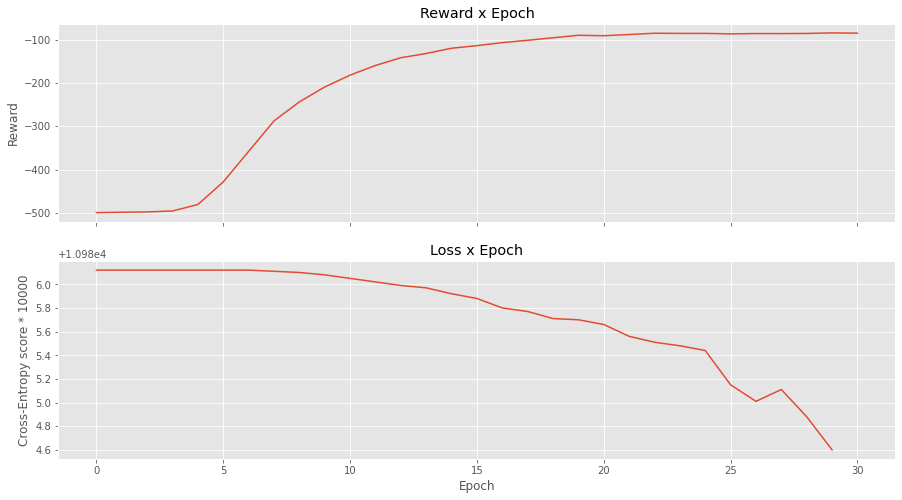

In [ ]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
    ax[0].plot(history['reward'])
    ax[0].set_title('Reward x Epoch')
    ax[0].set_ylabel('Reward')
    ax[1].plot(history['loss'][1:])
    ax[1].set_title('Loss x Epoch')
    ax[1].set_ylabel('Cross-Entropy score * 10000')
    ax[1].set_xlabel('Epoch')

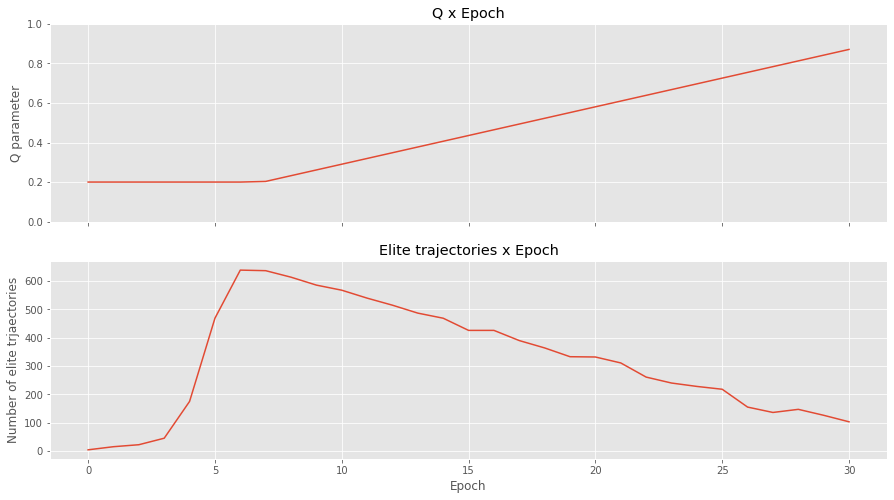

In [ ]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
    ax[0].plot(history['q_param'])
    ax[0].set_title('Q x Epoch')
    ax[0].set_ylabel('Q parameter')
    ax[0].set_ylim(0, 1)
    ax[1].plot(history['etn'])
    ax[1].set_title('Elite trajectories x Epoch')
    ax[1].set_ylabel('Number of elite trjaectories')
    ax[1].set_xlabel('Epoch')

In [ ]:
from scipy.stats import pearsonr

In [ ]:
def normalize(x: list):
    x = np.array(x)
    print(f'min={x.min()}, max={x.max()}, mean={x.mean()}, std={x.std()}')
    x = (x - x.mean()) / x.std()
    print(f'min={x.min()}, max={x.max()}, mean={x.mean()}, std={x.std()}')
    return x 

In [ ]:
print('Q_params')
q_params = normalize(history['q_param'])
print()

print('Elite trajectories numbers')
etns = normalize(history['etn'])
print()

Q_params
min=0.2, max=0.87097, mean=0.4609783870967742, std=0.2261265575148739
min=-1.1541253268299008, max=1.813106861082683, mean=-2.1488187573390126e-17, std=1.0

Elite trajectories numbers
min=4, max=639, mean=321.96774193548384, std=196.09600740634062
min=-1.6214901371072106, max=1.6167195969858648, mean=1.360918546314708e-16, std=1.0



In [ ]:
print('Pearson correlation for q_params and elite traj numbers: test statistic and p-value')
print(pearsonr(x=q_params, y=etns))

Pearson correlation for q_params and elite traj numbers: test statistic and p-value
(-0.360623644640199, 0.04626262179019945)


In [ ]:
print('Rewards')
rewards = normalize(history['reward'])

min=-499.47, max=-84.72, mean=-199.93967741935484, std=153.14561698958852
min=-1.9558530532480634, max=0.7523537381235531, mean=-7.520865650686544e-17, std=1.0


In [ ]:
print('Pearson correlation for q_params and rewards: test statistic and p-value')
print(pearsonr(x=q_params, y=rewards))

Pearson correlation for q_params and rewards: test statistic and p-value
(0.785917432259424, 1.6171057926465186e-07)


In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
history_df = pd.DataFrame(history)

In [ ]:
history_df = (history_df - history_df.mean()) / history_df.std()

In [ ]:
corr_mat = history_df.corr()

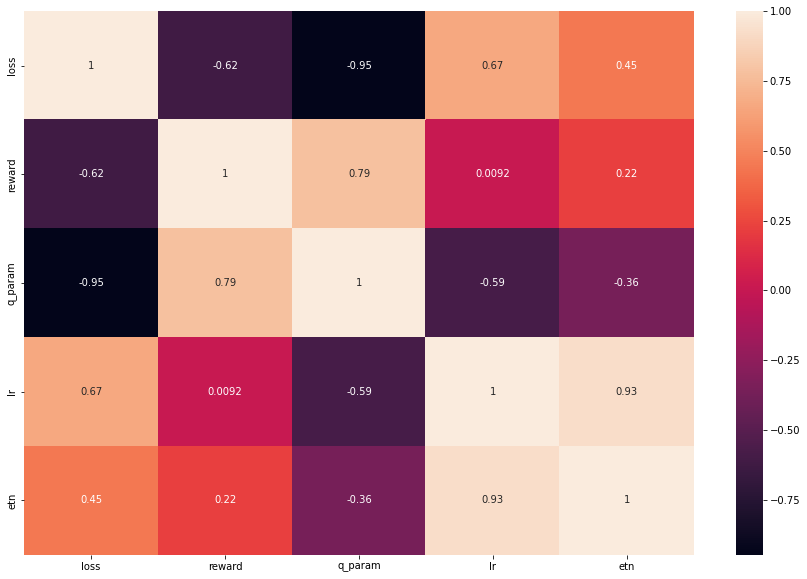

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, annot=True)
plt.show()